In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from gurobipy import *

## simple four-node, three-link topology

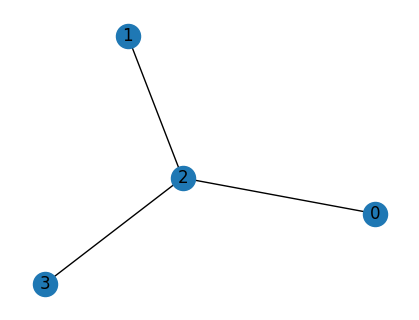

In [49]:
N = 4# number of nodes
G = nx.Graph()
G.add_nodes_from(np.arange(N))
adj_mat = np.array([[0,0,1,0],[0,0,1,0],[1,1,0,1],[0,0,1,0]])
G = nx.from_numpy_array(adj_mat)
# G.add_edges_from([(q,q+1) for q in range(N-1)])
plt.figure(figsize=(4,3))
nx.draw(G,  with_labels=True)
plt.show()
# adj_mat = nx.to_numpy_array(G)

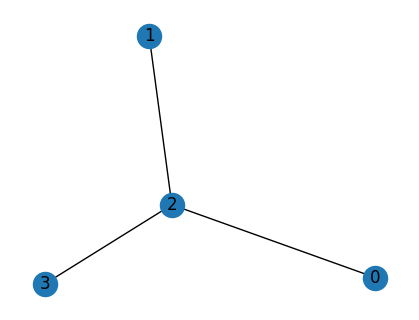

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 25 rows, 36 columns and 50 nonzeros
Model fingerprint: 0x47b4dc11
Coefficient statistics:
  Matrix range     [5e-02, 1e+00]
  Objective range  [5e-02, 5e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 2e+02]
Presolve removed 21 rows and 31 columns
Presolve time: 0.00s
Presolved: 4 rows, 5 columns, 13 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0000000e+01   1.249996e+01   0.000000e+00      0s
       2    2.0000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.000000000e+01


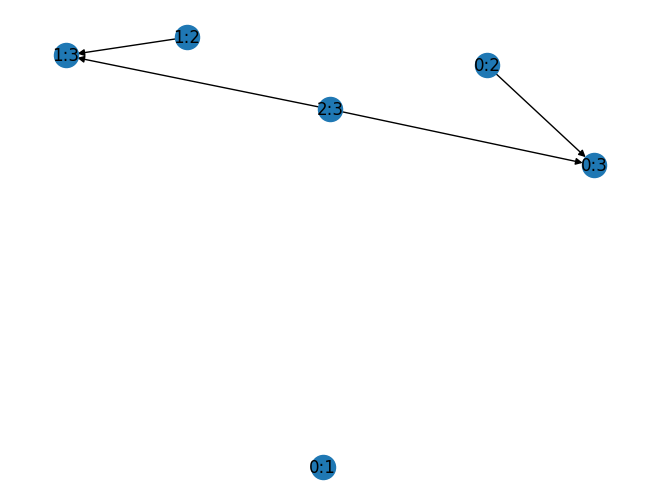

In [92]:
N = 4# number of nodes
G = nx.Graph()
G.add_nodes_from(np.arange(N))

q = 0.1
adj_mat = np.zeros((N,N))
adj_mat[0,2] = 100
adj_mat[1,2] = 100
adj_mat[2,3] = 200
adj_mat += adj_mat.T
G = nx.from_numpy_array(adj_mat)
# G.add_edges_from([(q,q+1) for q in range(N-1)])
plt.figure(figsize=(4,3))
nx.draw(G,  with_labels=True)
plt.show()

Eflow = nx.DiGraph()
for n1 in range(N):
    for n2 in range(n1+1,N):
        Eflow.add_node("%d:%d" % (n1,n2))
        
# indices: (superscript, subscript)
m = Model()
Ef_size = int(N*(N-1)/2)
f = m.addMVar((Ef_size,Ef_size), vtype=GRB.CONTINUOUS,name="f")

Ef_nodes = np.array(list(Eflow.nodes()))
s = "0"
t = "3"
st1 = np.argwhere(Ef_nodes== s+":"+t ) [0][0]
s = "1"
t = "3"
st2 = np.argwhere(Ef_nodes== s+":"+t ) [0][0]
st = np.array([st1,st2])

Ist = 0
for n1 in range(N):
    for n2 in range(n1+1,N):
        
        ab = np.argwhere(Ef_nodes== "%d:%d" % (n1,n2) ) [0][0]
        if ab in st:    
            for n3 in range(N):
                if n3 not in [n1,n2]:
                    ac = np.argwhere(Ef_nodes== "%d:%d" % (min(n1,n3), max(n1,n3)) ) [0][0]
                    bc = np.argwhere(Ef_nodes== "%d:%d" % (min(n2,n3), max(n2,n3)) ) [0][0]
                    Ist += q*(f[ac][ab]+f[bc][ab])/2
                    m.addConstr( f[ac][ab]==f[bc][ab] ) 
                    if ac in st or bc in st:
                        m.addConstr( f[bc][ab]==0 ) 
                        m.addConstr( f[ac][ab]==0 )                     
        else:
    #         print([n1,n2],e1)
#             if n2 == n1+1:
#             if G.has_edge(n1, n2):
#                 lhs = p_list[n1]
#             else:
            lhs = adj_mat[n1,n2]
            rhs = 0
            for n3 in range(N):
                if n3 not in [n1,n2]:
                    ac = np.argwhere(Ef_nodes== "%d:%d" % (min(n1,n3), max(n1,n3)) ) [0][0]
                    bc = np.argwhere(Ef_nodes== "%d:%d" % (min(n2,n3), max(n2,n3)) ) [0][0]
                    rhs += f[ab][ac]+f[ab][bc]
                    
                    if ac in st or bc in st:
#                         print([bc,ab],[ac,ab])
                        m.addConstr( f[bc][ab]==0 ) 
                        m.addConstr( f[ac][ab]==0 ) 
                    else:
#                         print([ac,ab],[bc,ab])
                        m.addConstr( f[ac][ab]==f[bc][ab] ) 
                        lhs += q*(f[ac][ab]+f[bc][ab])/2
                    
            m.addConstr(lhs >= rhs ) 
        
m.setObjective(Ist , GRB.MAXIMIZE)
m.optimize()


# Ef_nodes = list(Eflow.nodes())
for i in range(Ef_size):
    for j in range(Ef_size):
#         print([i,j],m.getVars()[i*Ef_size+j].X)
        if m.getVars()[i*Ef_size+j].X > 0:
#             print(m.getVars()[i*Ef_size+j].X)
#             print((Ef_nodes[i],Ef_nodes[j]))
            Eflow.add_edge(Ef_nodes[i],Ef_nodes[j])
        elif m.getVars()[i*Ef_size+j].X < 0:
            print(m.getVars()[i*Ef_size+j].X)

nx.draw(Eflow,  with_labels=True)

# components = [Eflow.subgraph(c).copy() for c in nx.connected_components(Eflow)]
# nx.draw(components[0],  with_labels=True)
plt.show()
# print(m.ObjVal)

In [91]:
f_opt = np.zeros((Ef_size,Ef_size))
for i in range(Ef_size):
    for j in range(Ef_size):
        if m.getVars()[i*Ef_size+j].X > 0:
#             print([Ef_nodes[i],Ef_nodes[j]],m.getVars()[i*Ef_size+j].X)
            f_opt[i,j] = m.getVars()[i*Ef_size+j].X

rates = np.zeros(len(st))
for i, ab in enumerate(st):
    ab_nodes = list(map(int, Ef_nodes[ab].split(":")))
    for n3 in range(N):
        if n3 not in ab_nodes:
            ac = np.argwhere(Ef_nodes== "%d:%d" % (min(ab_nodes[0],n3), max(ab_nodes[0],n3)) ) [0][0]
            bc = np.argwhere(Ef_nodes== "%d:%d" % (min(ab_nodes[1],n3), max(ab_nodes[1],n3)) ) [0][0]
            rates[i] += q*(f_opt[ac][ab]+f_opt[bc][ab])/2
    print(Ef_nodes[ab],rates[i])
print(np.sum(rates))

0:3 10.0
1:3 10.0
20.0


## dumbbell topology

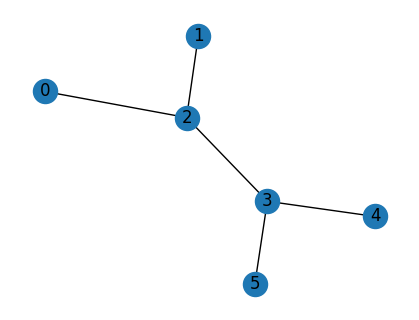

In [48]:
N = 6# number of nodes
G = nx.Graph()
G.add_nodes_from(np.arange(N))
adj_mat = np.zeros((N,N))
adj_mat[0,2] = 0.5
adj_mat[1,2] = 1
adj_mat[2,3] = 1
adj_mat[3,4] = 1
adj_mat[3,5] = 1
adj_mat += adj_mat.T
G = nx.from_numpy_array(adj_mat)
# G.add_edges_from([(q,q+1) for q in range(N-1)])
plt.figure(figsize=(4,3))
nx.draw(G,  with_labels=True)
plt.show()
# adj_mat = nx.to_numpy_array(G)

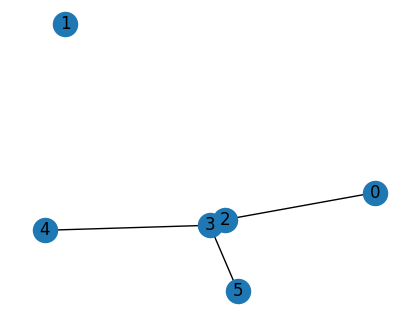

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 89 rows, 225 columns and 296 nonzeros
Model fingerprint: 0xd7dc71d5
Coefficient statistics:
  Matrix range     [5e-02, 1e+00]
  Objective range  [5e-02, 5e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+02]
Presolve removed 76 rows and 181 columns
Presolve time: 0.00s
Presolved: 13 rows, 44 columns, 124 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.0000000e+29   1.600000e+31   8.000000e-01      0s
      23    9.0909091e-03   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.090909091e-03


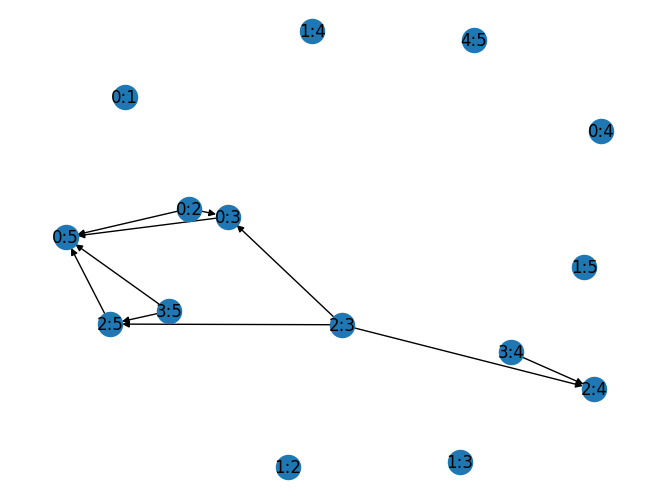

In [137]:
N = 6# number of nodes
G = nx.Graph()
G.add_nodes_from(np.arange(N))

p = 0.5            
q = 0.1
adj_mat = np.zeros((N,N))
adj_mat[0,2] = p
adj_mat[1,2] = 0
adj_mat[2,3] = 120
adj_mat[3,4] = p
adj_mat[3,5] = p
adj_mat += adj_mat.T
G = nx.from_numpy_array(adj_mat)
# G.add_edges_from([(q,q+1) for q in range(N-1)])
plt.figure(figsize=(4,3))
nx.draw(G,  with_labels=True)
plt.show()

Eflow = nx.DiGraph()
for n1 in range(N):
    for n2 in range(n1+1,N):
        Eflow.add_node("%d:%d" % (n1,n2))
        
# indices: (superscript, subscript)
m = Model()
Ef_size = int(N*(N-1)/2)
f = m.addMVar((Ef_size,Ef_size), vtype=GRB.CONTINUOUS,name="f")

Ef_nodes = np.array(list(Eflow.nodes()))
s = "0"
t = "5"
st1 = np.argwhere(Ef_nodes== s+":"+t ) [0][0]
s = "1"
t = "4"
st2 = np.argwhere(Ef_nodes== s+":"+t ) [0][0]
st = np.array([st1,st2])

Ist = 0
for n1 in range(N):
    for n2 in range(n1+1,N):
        
        ab = np.argwhere(Ef_nodes== "%d:%d" % (n1,n2) ) [0][0]
        if ab in st:    
            for n3 in range(N):
                if n3 not in [n1,n2]:
                    ac = np.argwhere(Ef_nodes== "%d:%d" % (min(n1,n3), max(n1,n3)) ) [0][0]
                    bc = np.argwhere(Ef_nodes== "%d:%d" % (min(n2,n3), max(n2,n3)) ) [0][0]
                    Ist += q*(f[ac][ab]+f[bc][ab])/2
                    if ac in st or bc in st:
                        m.addConstr( f[bc][ab]==0 ) 
                        m.addConstr( f[ac][ab]==0 ) 
                    else:
                        m.addConstr( f[ac][ab]==f[bc][ab] ) 
                    
        else:
    #         print([n1,n2],e1)
#             if n2 == n1+1:
#             if G.has_edge(n1, n2):
#                 lhs = p_list[n1]
#             else:
            lhs = adj_mat[n1,n2]
            rhs = 0
            for n3 in range(N):
                if n3 not in [n1,n2]:
                    ac = np.argwhere(Ef_nodes== "%d:%d" % (min(n1,n3), max(n1,n3)) ) [0][0]
                    bc = np.argwhere(Ef_nodes== "%d:%d" % (min(n2,n3), max(n2,n3)) ) [0][0]
                    rhs += f[ab][ac]+f[ab][bc]
                    
                    if ac in st or bc in st:
#                         print([bc,ab],[ac,ab])
                        m.addConstr( f[bc][ab]==0 ) 
                        m.addConstr( f[ac][ab]==0 ) 
                    else:
#                         print([ac,ab],[bc,ab])
                        m.addConstr( f[ac][ab]==f[bc][ab] ) 
                        lhs += q*(f[ac][ab]+f[bc][ab])/2
                    
            m.addConstr(lhs >= rhs ) 
        
m.setObjective(Ist , GRB.MAXIMIZE)
m.optimize()


# Ef_nodes = list(Eflow.nodes())
for i in range(Ef_size):
    for j in range(Ef_size):
#         print([i,j],m.getVars()[i*Ef_size+j].X)
        if m.getVars()[i*Ef_size+j].X > 0:
#             print(m.getVars()[i*Ef_size+j].X)
#             print((Ef_nodes[i],Ef_nodes[j]))
            Eflow.add_edge(Ef_nodes[i],Ef_nodes[j],weight=m.getVars()[i*Ef_size+j].X)
        elif m.getVars()[i*Ef_size+j].X < 0:
            print(m.getVars()[i*Ef_size+j].X)

nx.draw(Eflow,  with_labels=True)

# components = [Eflow.subgraph(c).copy() for c in nx.connected_components(Eflow)]
# nx.draw(components[0],  with_labels=True)
plt.show()
# print(m.ObjVal)

In [132]:
f_opt = np.zeros((Ef_size,Ef_size))
for i in range(Ef_size):
    for j in range(Ef_size):
        if m.getVars()[i*Ef_size+j].X > 0:
#             print([Ef_nodes[i],Ef_nodes[j]],m.getVars()[i*Ef_size+j].X)
            f_opt[i,j] = m.getVars()[i*Ef_size+j].X

rates = np.zeros(len(st))
for i, ab in enumerate(st):
    ab_nodes = list(map(int, Ef_nodes[ab].split(":")))
    for n3 in range(N):
        if n3 not in ab_nodes:
            ac = np.argwhere(Ef_nodes== "%d:%d" % (min(ab_nodes[0],n3), max(ab_nodes[0],n3)) ) [0][0]
            bc = np.argwhere(Ef_nodes== "%d:%d" % (min(ab_nodes[1],n3), max(ab_nodes[1],n3)) ) [0][0]
            rates[i] += q*(f_opt[ac][ab]+f_opt[bc][ab])/2
    print(Ef_nodes[ab],rates[i])
print(np.sum(rates))

0:5 20.0
1:4 100.0
120.0
